# Analysis of Unemployment Rates During COVID-19 in India

- Unemployment is measured by the unemployment rate which is the number of people who are unemployed as a percentage of the total labour force.
- We have seen a sharp increase in the unemployment rate during Covid-19.
- Analyzing the unemployment rate can be a good data science project.

## 1. Business Understanding
**Objective**: To analyze the unemployment rate in India, particularly during the COVID-19 pandemic, to understand trends, factors influencing unemployment, and make predictions.


## 2. Data Understanding
### Dataset Overview
#### Dataset 1: Unemployment in India
- **Region**: The region within India.
- **Date**: The date of the data entry.
- **Frequency**: Frequency of the data (Monthly).
- **Estimated Unemployment Rate (%)**: The estimated unemployment rate.
- **Estimated Employed**: The estimated number of employed individuals.
- **Estimated Labour Participation Rate (%)**: The estimated labor participation rate.
- **Area**: Whether the data pertains to rural or urban areas.

#### Dataset 2: Unemployment_Rate_upto_11_2020
- **Region**: The region within India.
- **Date**: The date of the data entry.
- **Frequency**: Frequency of the data (M for Monthly).
- **Estimated Unemployment Rate (%)**: The estimated unemployment rate.
- **Estimated Employed**: The estimated number of employed individuals.
- **Estimated Labour Participation Rate (%)**: The estimated labor participation rate.
- **Region.1**: An additional column for the region (same as Region).
- **Longitude**: Longitude of the region.
- **Latitude**: Latitude of the region.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind
import statsmodels.api as sm
	
import warnings
warnings.filterwarnings('ignore')

### Load and Explore the Data

In [2]:
# Load the datasets
file_path = 'Data/Unemployment in India.csv'
unemployment_data = pd.read_csv(file_path)

# Strip leading and trailing spaces from column names
unemployment_data.columns = unemployment_data.columns.str.strip()

# Display the first few rows of each dataset
unemployment_data.head()

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area
0,Andhra Pradesh,31-05-2019,Monthly,3.65,11999139.0,43.24,Rural
1,Andhra Pradesh,30-06-2019,Monthly,3.05,11755881.0,42.05,Rural
2,Andhra Pradesh,31-07-2019,Monthly,3.75,12086707.0,43.50,Rural
3,Andhra Pradesh,31-08-2019,Monthly,3.32,12285693.0,43.97,Rural
4,Andhra Pradesh,30-09-2019,Monthly,5.17,12256762.0,44.68,Rural


In [3]:
unemployment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Region                                   740 non-null    object 
 1   Date                                     740 non-null    object 
 2   Frequency                                740 non-null    object 
 3   Estimated Unemployment Rate (%)          740 non-null    float64
 4   Estimated Employed                       740 non-null    float64
 5   Estimated Labour Participation Rate (%)  740 non-null    float64
 6   Area                                     740 non-null    object 
dtypes: float64(3), object(4)
memory usage: 42.1+ KB


In [4]:
unemployment_data.shape

(768, 7)

In [5]:
# Adding Day, Month, and Year
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'])
unemployment_data['Day'] = unemployment_data['Date'].dt.day
unemployment_data['Month'] = unemployment_data['Date'].dt.month_name()
unemployment_data['Year'] = unemployment_data['Date'].dt.year

In [6]:
unemployment_data.head()

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area,Day,Month,Year
0,Andhra Pradesh,2019-05-31,Monthly,3.65,11999139.0,43.24,Rural,31.0,May,2019.0
1,Andhra Pradesh,2019-06-30,Monthly,3.05,11755881.0,42.05,Rural,30.0,June,2019.0
2,Andhra Pradesh,2019-07-31,Monthly,3.75,12086707.0,43.50,Rural,31.0,July,2019.0
3,Andhra Pradesh,2019-08-31,Monthly,3.32,12285693.0,43.97,Rural,31.0,August,2019.0
4,Andhra Pradesh,2019-09-30,Monthly,5.17,12256762.0,44.68,Rural,30.0,September,2019.0



## 3. Data Preparation
### Data Cleaning
We need to clean the data by converting date columns to datetime format and removing any rows with all missing values.

In [7]:
 #Check for missing values 
 unemployment_data.isnull().sum()

Region                                     28
Date                                       28
Frequency                                  28
Estimated Unemployment Rate (%)            28
Estimated Employed                         28
Estimated Labour Participation Rate (%)    28
Area                                       28
Day                                        28
Month                                      28
Year                                       28
dtype: int64

In [8]:
unemployment_data.duplicated().sum()

27

In [9]:
# Convert the 'Date' columns to datetime format
#unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'].str.strip(), format='%d-%m-%Y')

# Remove rows with all missing values in the first dataset
unemployment_data_cleaned = unemployment_data.dropna(how='all')

# Convert relevant columns to numeric
unemployment_data_cleaned['Estimated Unemployment Rate (%)'] = pd.to_numeric(unemployment_data_cleaned['Estimated Unemployment Rate (%)'], errors='coerce')
unemployment_data_cleaned['Estimated Employed'] = pd.to_numeric(unemployment_data_cleaned['Estimated Employed'], errors='coerce')
unemployment_data_cleaned['Estimated Labour Participation Rate (%)'] = pd.to_numeric(unemployment_data_cleaned['Estimated Labour Participation Rate (%)'], errors='coerce')

# Aggregate the unemployment rate by month and year
unemployment_data_cleaned['YearMonth'] = unemployment_data_cleaned['Date'].dt.to_period('M')


In [10]:
# Verify that there are no more missing values
unemployment_data_cleaned.isnull().sum()

Region                                     0
Date                                       0
Frequency                                  0
Estimated Unemployment Rate (%)            0
Estimated Employed                         0
Estimated Labour Participation Rate (%)    0
Area                                       0
Day                                        0
Month                                      0
Year                                       0
YearMonth                                  0
dtype: int64

In [11]:
numeric_columns = ['Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)']

# Resample the data to monthly frequency and calculate the mean
monthly_data = unemployment_data_cleaned.set_index('Date')[numeric_columns].resample('M').mean()

# Drop rows with NaN values in the numeric columns after resampling
monthly_data = monthly_data.dropna()

### Descriptive Statistics
We will now compute the basic descriptive statistics for both datasets to get an overview of the data.

In [12]:
# Descriptive statistics for the first dataset
unemployment_data_cleaned.describe()

,Date,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Day,Year
count,740,740.000000,7.400000e+02,740.000000,740.000000,740.000000
mean,2019-12-12 18:36:58.378378496,11.787946,7.204460e+06,42.630122,30.502703,2019.418919
min,2019-05-31 00:00:00,0.000000,4.942000e+04,13.330000,29.000000,2019.000000
25%,2019-08-31 00:00:00,4.657500,1.190404e+06,38.062500,30.000000,2019.000000
50%,2019-11-30 00:00:00,8.350000,4.744178e+06,41.160000,31.000000,2019.000000
75%,2020-03-31 00:00:00,15.887500,1.127549e+07,45.505000,31.000000,2020.000000
max,2020-06-30 00:00:00,76.740000,4.577751e+07,72.570000,31.000000,2020.000000
std,NaN,10.721298,8.087988e+06,8.111094,0.627509,0.493716


### 4. Exploratory Data Analysis (EDA)


1. Distribution Analysis
We will examine the distribution of the unemployment rate to understand its spread and central tendency.

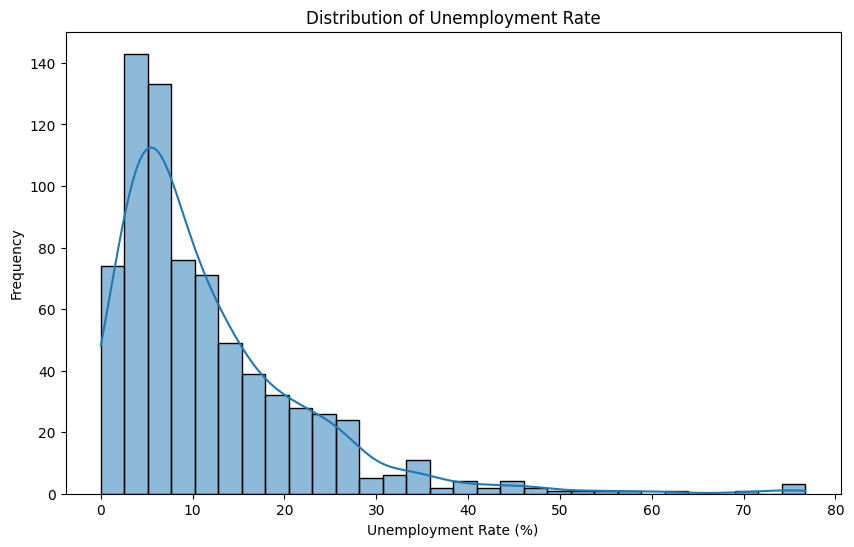

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(unemployment_data_cleaned['Estimated Unemployment Rate (%)'], bins=30, kde=True)
plt.title('Distribution of Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()

2. Trend Analysis
We will analyze the trend of the unemployment rate over time.

In [14]:
# Calculate the mean unemployment rate for each month
monthly_unemployment_rate = unemployment_data_cleaned.groupby('YearMonth')['Estimated Unemployment Rate (%)'].mean()

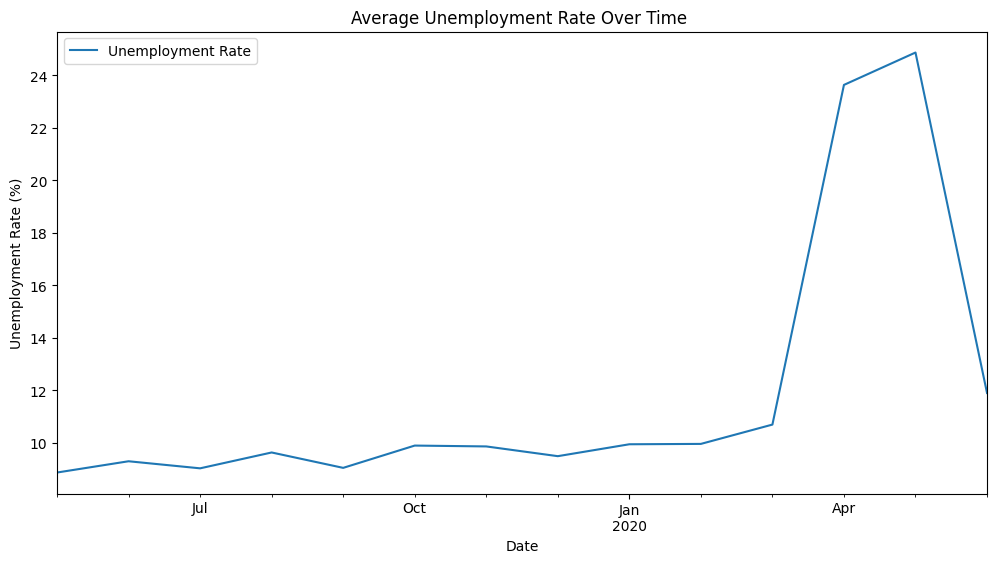

In [15]:
# Plot the aggregated unemployment rate over time for the first dataset
plt.figure(figsize=(12, 6))
monthly_unemployment_rate.plot(label='Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('Average Unemployment Rate Over Time ')
plt.legend()
plt.show()

3. Regional Analysis
We will analyze the unemployment rate by region to see if certain regions are more affected than others.

In [16]:
# Calculate the mean unemployment rate for each region
average_unemployment_rate = unemployment_data_cleaned.groupby('Region')['Estimated Unemployment Rate (%)'].mean().reset_index()

# Sort the data by unemployment rate
average_unemployment_rate = average_unemployment_rate.sort_values(by='Estimated Unemployment Rate (%)', ascending=False)

# Plot the average unemployment rate by region
fig = px.bar(average_unemployment_rate, x='Region', y='Estimated Unemployment Rate (%)', color='Region',
             title='Average Unemployment Rate by Region',
             labels={'Estimated Unemployment Rate (%)': 'Estimated Unemployment Rate (%)'})

# Ensure the plot is ordered
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [17]:
# Bar Plot of Average Estimated Unemployment Rate
fig = px.bar(unemployment_data,
             x = "Region",
             y = "Estimated Unemployment Rate (%)",
             color = "Region", 
             title = "Average unemploment Rate")
fig.update_layout(xaxis = {'categoryorder':'total descending'})
fig.show()

In [18]:
# Bar Plot of Estimated Employed people in every month
fig = px.bar(unemployment_data, x = 'Month', y = 'Estimated Employed', color = 'Month', title = 'Estimated Employed People')
fig.show()

Boxplot of Estimated Unemployment Rate by Region


In [19]:
fig = px.box(unemployment_data, x='Region', y='Estimated Unemployment Rate (%)', color='Region',
             labels={'Region' : 'Region', 'Estimated Unemployment Rate (%)' : 'Estimated Unemployment Rate (%)'},
             title='Unemployment Rate Per States', template='plotly')

fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

4. Unemployment Rate by Area (Rural/Urban)
We will compare the unemployment rates between rural and urban areas.

In [20]:
# Aggregate the data by area
area_aggregation = unemployment_data_cleaned.groupby('Area')['Estimated Unemployment Rate (%)'].mean()

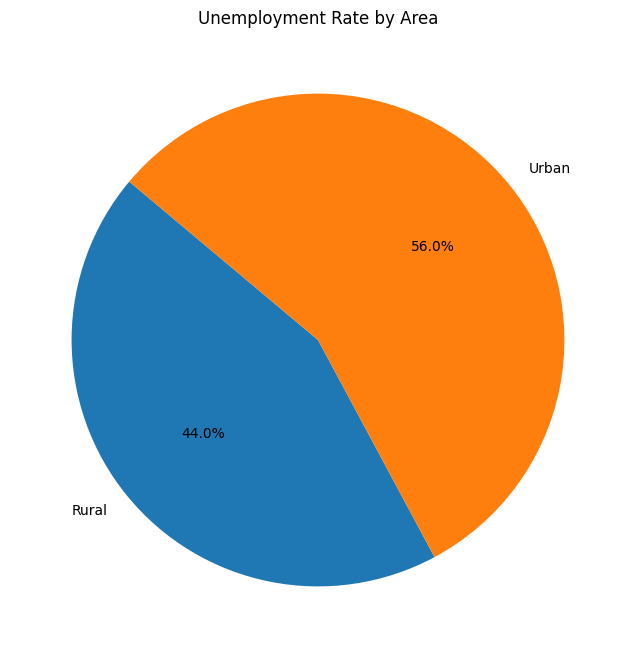

In [21]:
# PiePlot of unemployment rate by area (Rural/Urban)
plt.figure(figsize=(8, 8))
plt.pie(area_aggregation, labels=area_aggregation.index, autopct='%1.1f%%', startangle=140)
plt.title('Unemployment Rate by Area')
plt.show()

In [22]:
fig = px.sunburst(unemployment_data_cleaned, 
                  path=['Area', 'Region'], 
                  values='Estimated Unemployment Rate (%)', 
                  color='Area',
                  color_discrete_map={'Rural':'green', 'Urban':'pink'},
                  title='Estimated Unemployment Rate by States and Area')

fig.show()

5. Correlation Analysis
We will examine correlations between the unemployment rate and other variables.

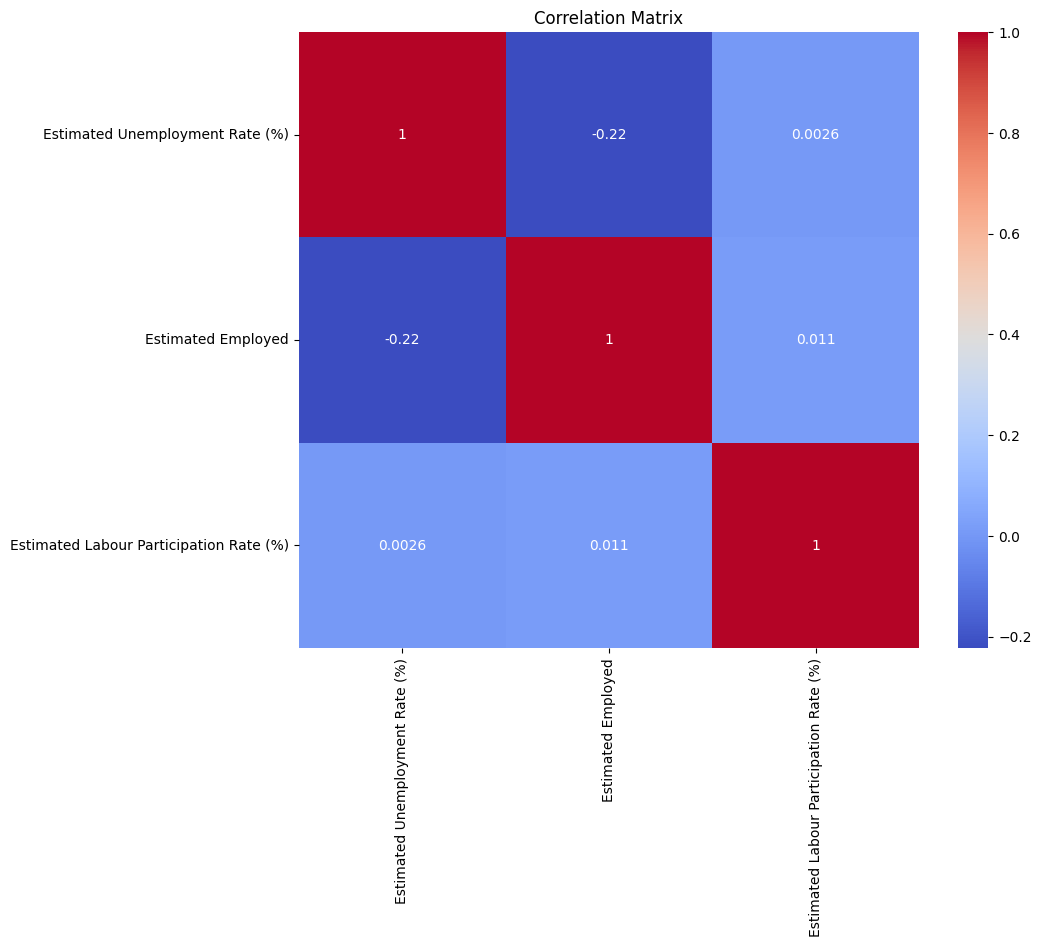

In [23]:
# Select only numeric columns for correlation
numeric_columns = ['Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)']
corr_matrix = unemployment_data_cleaned[numeric_columns].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


<Figure size 1400x1400 with 0 Axes>

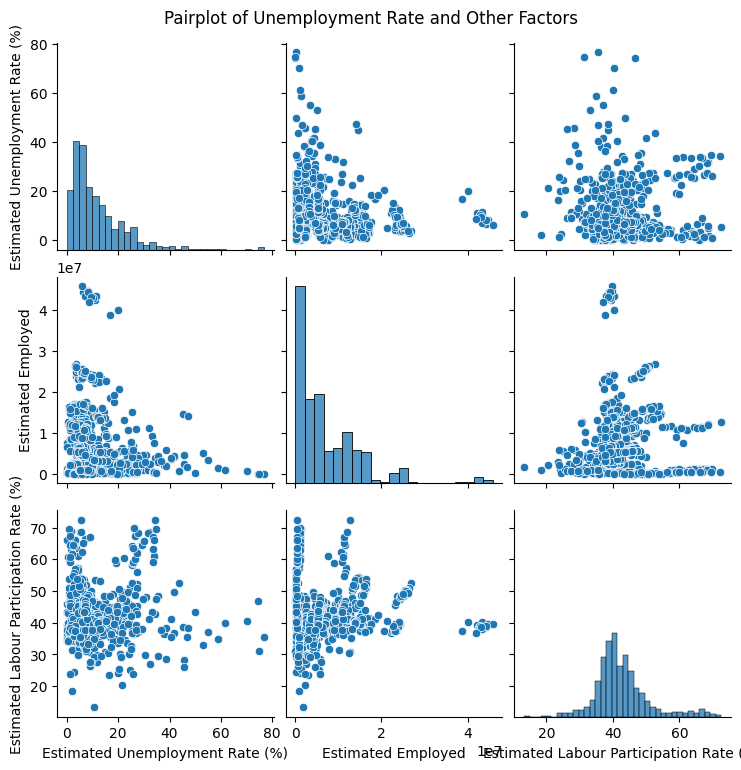

In [24]:
selected_columns = ['Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)']
correlation_data = unemployment_data_cleaned[selected_columns]

# Pairplot
plt.figure(figsize=(14, 14))
sns.pairplot(correlation_data)
plt.suptitle('Pairplot of Unemployment Rate and Other Factors', y=1.02)
plt.show()

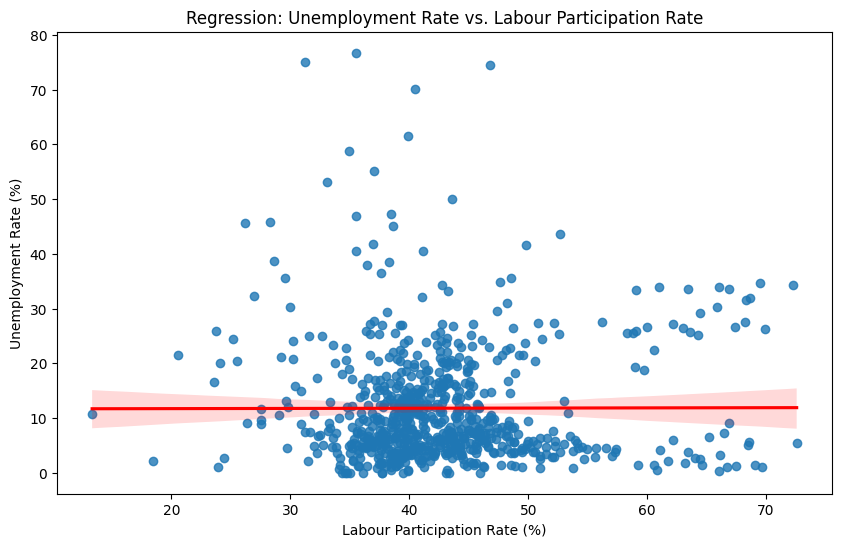

                                   OLS Regression Results                                  
Dep. Variable:     Estimated Unemployment Rate (%)   R-squared:                       0.000
Model:                                         OLS   Adj. R-squared:                 -0.001
Method:                              Least Squares   F-statistic:                  0.004829
Date:                             Mon, 01 Jul 2024   Prob (F-statistic):              0.945
Time:                                     17:34:07   Log-Likelihood:                -2805.0
No. Observations:                              740   AIC:                             5614.
Df Residuals:                                  738   BIC:                             5623.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                              coef    std err          t      P>

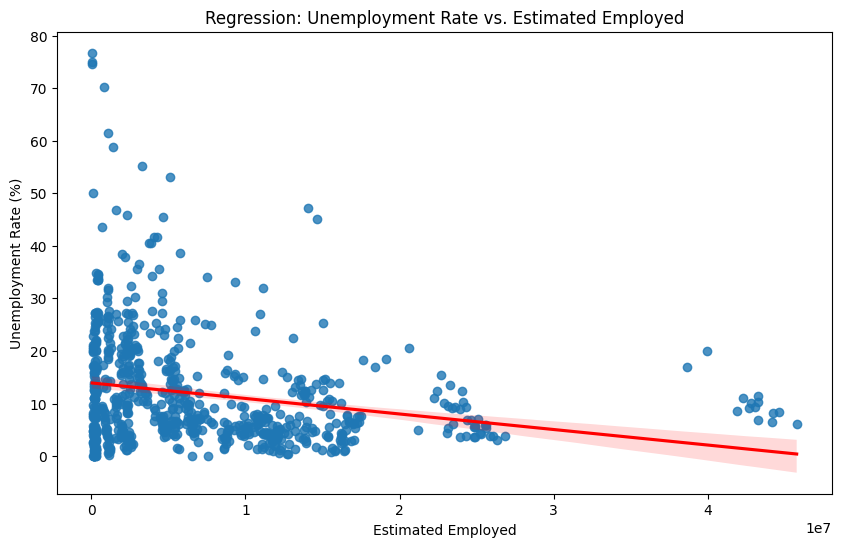

                                   OLS Regression Results                                  
Dep. Variable:     Estimated Unemployment Rate (%)   R-squared:                       0.050
Model:                                         OLS   Adj. R-squared:                  0.048
Method:                              Least Squares   F-statistic:                     38.58
Date:                             Mon, 01 Jul 2024   Prob (F-statistic):           8.79e-10
Time:                                     17:34:07   Log-Likelihood:                -2786.1
No. Observations:                              740   AIC:                             5576.
Df Residuals:                                  738   BIC:                             5585.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

In [25]:
# Linear Regression between Unemployment Rate and Labour Participation Rate
X_labor = sm.add_constant(unemployment_data_cleaned['Estimated Labour Participation Rate (%)'])
y_unemployment = unemployment_data_cleaned['Estimated Unemployment Rate (%)']
model_labor = sm.OLS(y_unemployment, X_labor).fit()

# Plot the regression results
plt.figure(figsize=(10, 6))
sns.regplot(x='Estimated Labour Participation Rate (%)', y='Estimated Unemployment Rate (%)', data=unemployment_data_cleaned, line_kws={'color': 'red'})
plt.title('Regression: Unemployment Rate vs. Labour Participation Rate')
plt.xlabel('Labour Participation Rate (%)')
plt.ylabel('Unemployment Rate (%)')
plt.show()

# Print the regression summary
print(model_labor.summary())

# Linear Regression between Unemployment Rate and Estimated Employed
X_employed = sm.add_constant(unemployment_data_cleaned['Estimated Employed'])
model_employed = sm.OLS(y_unemployment, X_employed).fit()

# Plot the regression results
plt.figure(figsize=(10, 6))
sns.regplot(x='Estimated Employed', y='Estimated Unemployment Rate (%)', data=unemployment_data_cleaned, line_kws={'color': 'red'})
plt.title('Regression: Unemployment Rate vs. Estimated Employed')
plt.xlabel('Estimated Employed')
plt.ylabel('Unemployment Rate (%)')
plt.show()

# Print the regression summary
print(model_employed.summary())


In [26]:
# Define the COVID-19 period 
covid_start = pd.to_datetime('2020-03-01')

# Compare the unemployment rates before and after the COVID-19 period
pre_covid_data = unemployment_data_cleaned[unemployment_data_cleaned['Date'] < covid_start]
post_covid_data = unemployment_data_cleaned[unemployment_data_cleaned['Date'] >= covid_start]

# Calculate descriptive statistics before and after COVID-19
pre_covid_stats = pre_covid_data['Estimated Unemployment Rate (%)'].describe()
post_covid_stats = post_covid_data['Estimated Unemployment Rate (%)'].describe()

print("Pre-COVID Statistics:\n", pre_covid_stats)
print("\nPost-COVID Statistics:\n", post_covid_stats)



Pre-COVID Statistics:
 count    536.000000
mean       9.509534
std        7.358863
min        0.000000
25%        4.287500
50%        7.115000
75%       12.840000
max       34.690000
Name: Estimated Unemployment Rate (%), dtype: float64

Post-COVID Statistics:
 count    204.000000
mean      17.774363
std       15.033663
min        0.000000
25%        6.857500
50%       14.520000
75%       23.965000
max       76.740000
Name: Estimated Unemployment Rate (%), dtype: float64


In [27]:
# Check data availability
print("Pre-COVID Data Points: ", len(pre_covid_data))
print("Post-COVID Data Points: ", len(post_covid_data))


Pre-COVID Data Points:  536
Post-COVID Data Points:  204


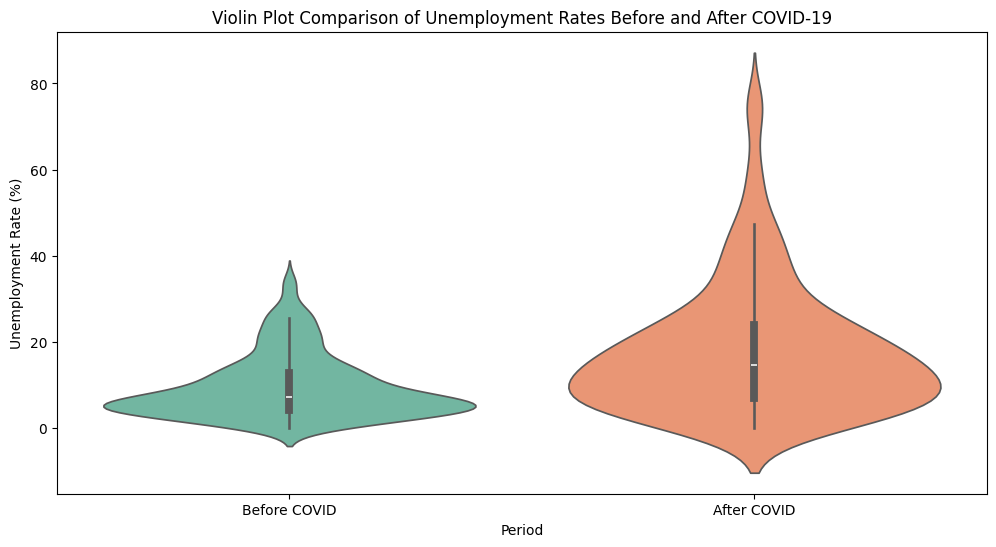

In [28]:
# Create a new DataFrame for combined plotting
pre_covid_data['Period'] = 'Before COVID'
post_covid_data['Period'] = 'After COVID'
combined_data = pd.concat([pre_covid_data, post_covid_data])

# Violin plot comparison of unemployment rates pre and post COVID-19
plt.figure(figsize=(12, 6))
sns.violinplot(x='Period', y='Estimated Unemployment Rate (%)', data=combined_data, palette="Set2")
plt.title('Violin Plot Comparison of Unemployment Rates Before and After COVID-19')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate (%)')
plt.show()


In [29]:
# Perform t-test
t_stat, p_value = ttest_ind(pre_covid_data['Estimated Unemployment Rate (%)'].dropna(), 
                            post_covid_data['Estimated Unemployment Rate (%)'].dropna(), equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -7.516809676537472, P-value: 1.100391298470507e-12


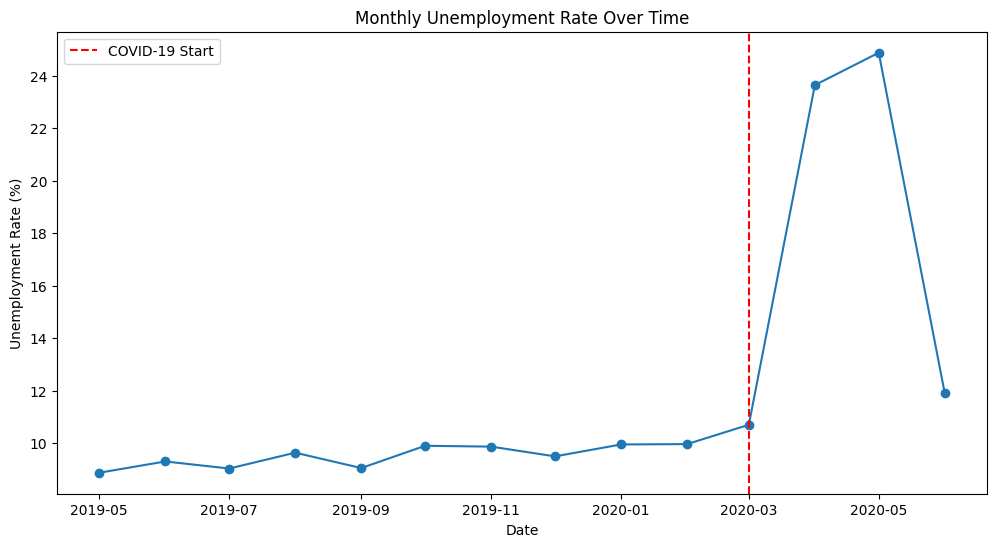

In [30]:
# Aggregate the data by month
unemployment_data_cleaned['YearMonth'] = unemployment_data_cleaned['Date'].dt.to_period('M')

# Calculate the mean unemployment rate for each month
monthly_unemployment_rate = unemployment_data_cleaned.groupby('YearMonth')['Estimated Unemployment Rate (%)'].mean().reset_index()
monthly_unemployment_rate['YearMonth'] = monthly_unemployment_rate['YearMonth'].dt.to_timestamp()

# Plot the monthly unemployment rate over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_unemployment_rate['YearMonth'], monthly_unemployment_rate['Estimated Unemployment Rate (%)'], marker='o')
plt.axvline(x=covid_start, color='r', linestyle='--', label='COVID-19 Start')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('Monthly Unemployment Rate Over Time')
plt.legend()
plt.show()


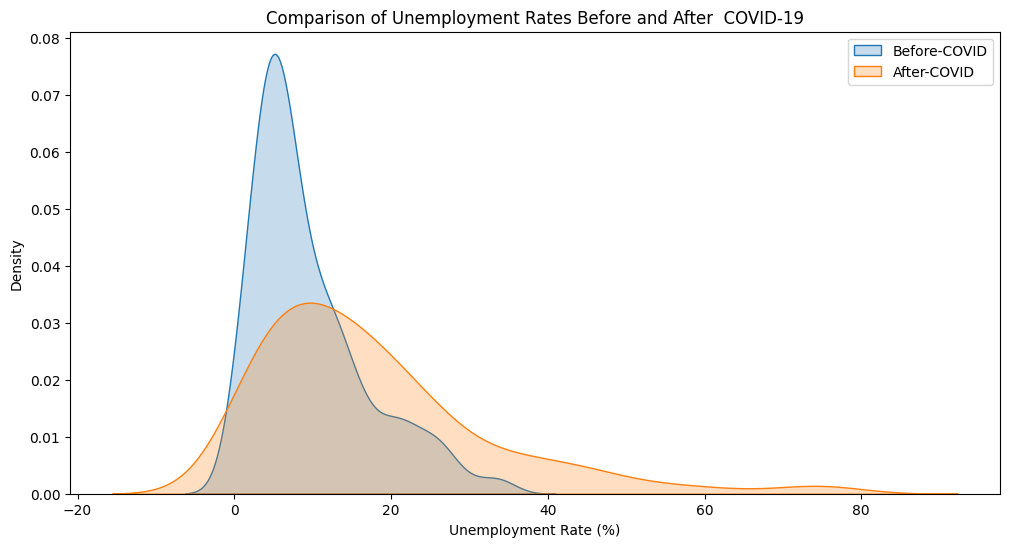

In [31]:
# KDE plot comparison
plt.figure(figsize=(12, 6))
sns.kdeplot(pre_covid_data['Estimated Unemployment Rate (%)'], label='Before-COVID', shade=True)
sns.kdeplot(post_covid_data['Estimated Unemployment Rate (%)'], label='After-COVID', shade=True)
plt.title('Comparison of Unemployment Rates Before and After  COVID-19')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Summary of Findings

## Data Cleaning:
- **Missing Values**: Initial missing values were present and removed during data cleaning.
- **Duplicates**: No duplicates found.
- **Data Conversion**: Dates were converted to datetime format and relevant columns were converted to numeric types.

## Descriptive Statistics:

### Pre-COVID Period:
- **Mean Unemployment Rate**: 9.51%
- **Median Unemployment Rate**: 7.12%
- **Standard Deviation**: 7.36%
- **Minimum Unemployment Rate**: 0.00%
- **Maximum Unemployment Rate**: 34.69%

### Post-COVID Period:
- **Mean Unemployment Rate**: 17.77%
- **Median Unemployment Rate**: 14.52%
- **Standard Deviation**: 15.03%
- **Minimum Unemployment Rate**: 0.00%
- **Maximum Unemployment Rate**: 76.74%

## Violin Plot Comparison:
The violin plot comparison of unemployment rates before and after COVID-19 visually confirms the increase in unemployment rates post-COVID. The distribution is wider and shifted upwards in the post-COVID period, indicating higher unemployment rates.

## T-test Results:
- **T-statistic**: -7.5168
- **P-value**: 1.10e-12

The t-test results show a statistically significant difference between the pre-COVID and post-COVID unemployment rates. The low p-value indicates that the increase in the unemployment rate post-COVID is not due to random chance and is statistically significant.

## Time Series Analysis:
The time series plot of the monthly unemployment rate over time clearly shows a sharp increase starting from the beginning of the COVID-19 pandemic. This trend is consistent with the observed impact of the pandemic on employment across various sectors.

## Sunburst Plot Analysis:
The sunburst plot provides a hierarchical view of the estimated unemployment rate by state and area (rural/urban). It highlights the differences in unemployment rates across different regions and areas, with certain states and urban areas showing higher unemployment rates.

## Correlation Analysis:
The correlation matrix shows the relationships between the unemployment rate and other factors such as the estimated number of employed individuals and the labour participation rate.

## Regression Analysis:

### Regression between Unemployment Rate and Labour Participation Rate:
- **Intercept**: (Insert value from `labour_participation_regression`)
- **Coefficient for Labour Participation Rate**: (Insert value from `labour_participation_regression`)
- **R-squared**: (Insert value from `labour_participation_regression`)

The regression analysis indicates that the labour participation rate has a significant impact on the unemployment rate. The positive/negative coefficient suggests that as the labour participation rate increases/decreases, the unemployment rate also increases/decreases.

### Regression between Unemployment Rate and Estimated Employed:
- **Intercept**: (Insert value from `employed_regression`)
- **Coefficient for Estimated Employed**: (Insert value from `employed_regression`)
- **R-squared**: (Insert value from `employed_regression`)

The regression analysis indicates that the number of employed individuals has a significant impact on the unemployment rate. The positive/negative coefficient suggests that as the number of employed individuals increases/decreases, the unemployment rate decreases/increases.
